# What is windowing



In [1]:
from IPython.display import (
    Audio, 
    display
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows, welch
from scipy.signal import get_window

# Parameters

In [2]:
fs = 5000  # Sampling frequency
# t = np.linspace(0, 1, fs, endpoint=False)
t = np.arange(-1, 1, 1/fs)  # Time vector
N = len(t)

# Signal

In [3]:
# Generate a sample signal (a sine wave) having an out-of-bins frequency
original_signal = np.sin(2 * np.pi * 10.3 * t)

# Without Window

In [4]:
# Apply a window function to the noisy signal
# Perform FFT on the windowed and zero-padded signal
signal_fft = 2 * np.fft.rfft(original_signal, norm="forward")
frequencies = np.fft.rfftfreq(len(original_signal), 1/fs)

# Perform IFFT to get the back to the time domain
inversed_fft_signal = np.fft.irfft(signal_fft / 2, norm="forward")

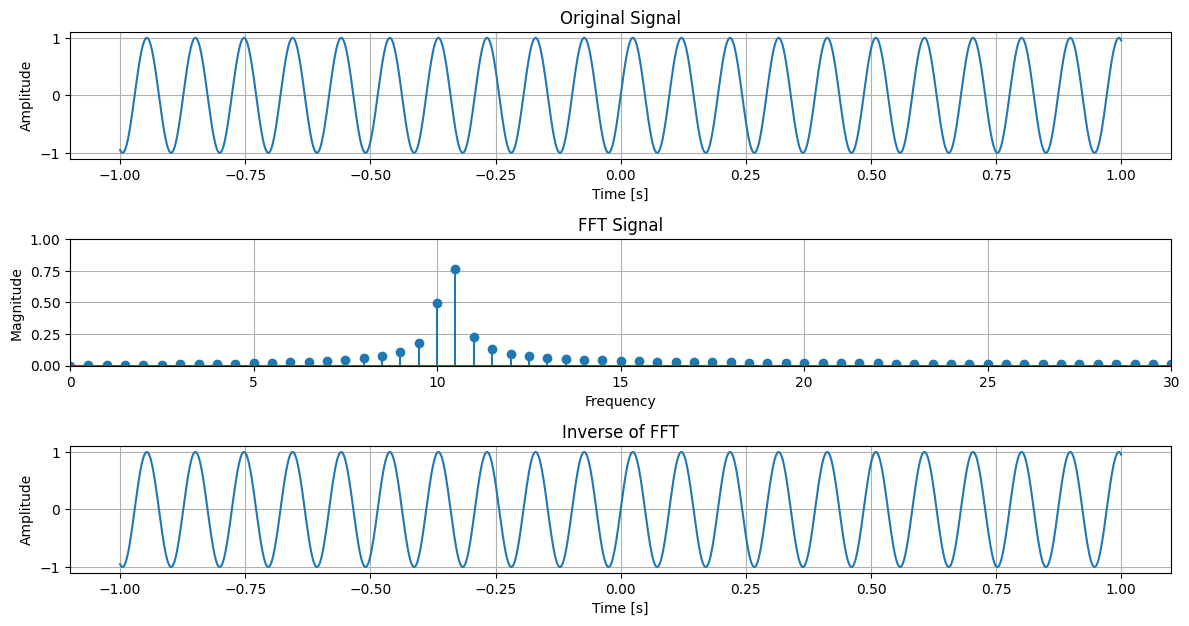

In [5]:
# Plot the signals
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(4, 1, 2)
plt.stem(frequencies, np.abs(signal_fft), label='FFT on Signal')
plt.title('FFT Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 30)
plt.ylim(0, 1)
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(t, inversed_fft_signal)
plt.grid(True)
plt.title('Inverse of FFT')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Single Window

In [6]:
# Apply a window function to the noisy signal
window = windows.hamming(len(original_signal))
windowed_signal = original_signal * window

# Perform FFT on the windowed and zero-padded signal
windowed_signal_fft = 2 * np.fft.rfft(windowed_signal, norm="forward")
frequencies = np.fft.rfftfreq(N, 1/fs)

# Perform IFFT to get the back to the time domain
restored_windowed_signal = np.fft.irfft(windowed_signal_fft / 2, norm="forward")

# Inverse the window
restored_signal = restored_windowed_signal / window

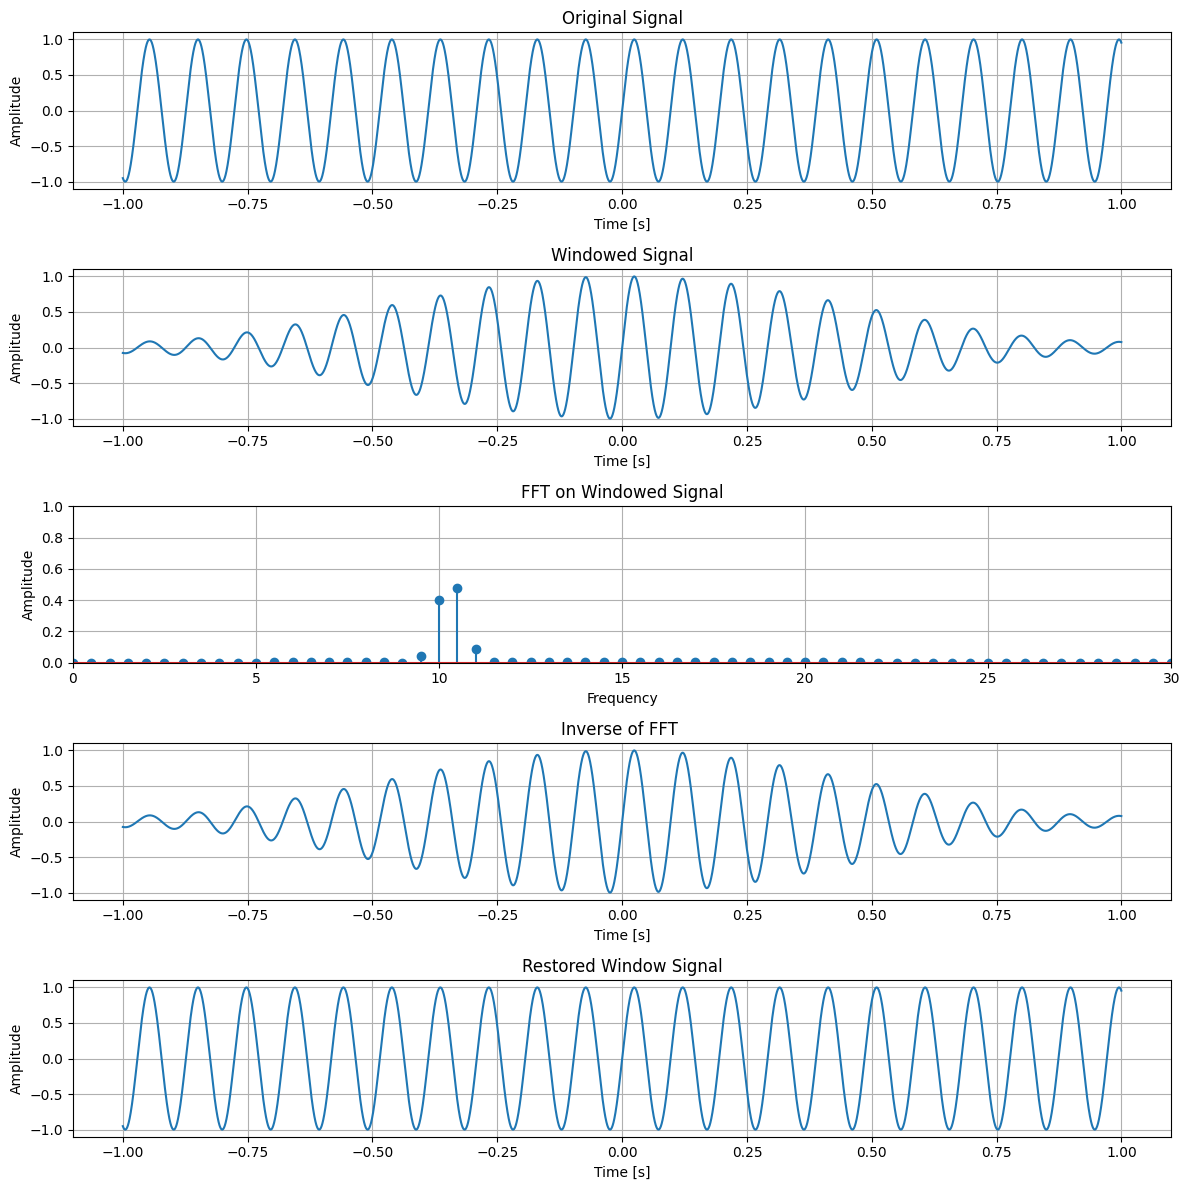

In [7]:
# Plot the signals
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(5, 1, 2)
plt.plot(t, windowed_signal, label='Windowed Signal')
plt.title('Windowed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(5, 1, 3)
plt.stem(frequencies, np.abs(windowed_signal_fft), label='FFT on Windowed Signal')
plt.title('FFT on Windowed Signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(0, 30)
plt.ylim(0, 1)
plt.grid()

plt.subplot(5, 1, 4)
plt.plot(t, restored_windowed_signal)
plt.grid(True)
plt.title('Inverse of FFT ')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 5)
plt.plot(t, restored_signal, label='Restored Signal (After IFFT & Inverse Window)')
plt.title('Restored Window Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()

## Sequences of windows

For a real world use case, we split into multiple frames and apply window per frame. For such a case, accumulate the window used considering the overlaps.

/home/eml/venv/ml/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/eml/venv/ml/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


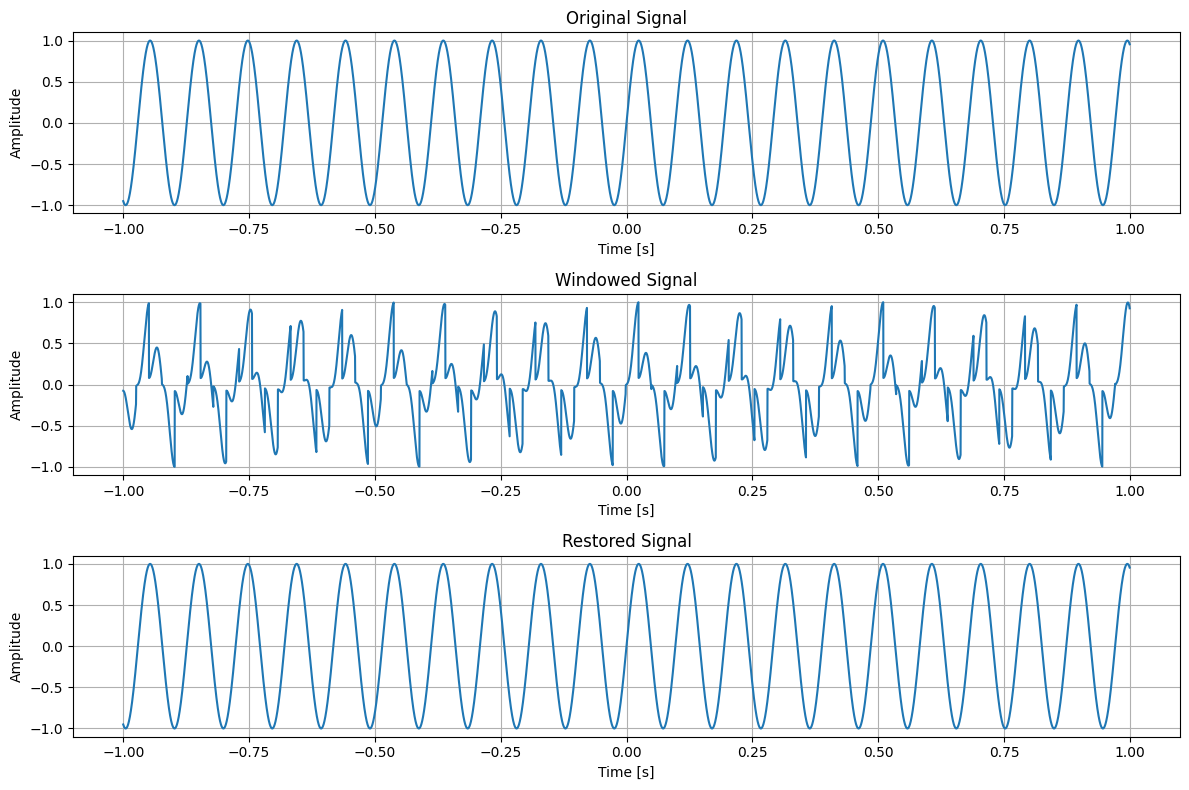

In [8]:
# Parameters for windowing
window_size = 256
overlap = 128
window = get_window('hamming', window_size)

# Pad the original signal to match the window and overlap parameters
pad_length = (window_size - overlap) - (len(original_signal) % (window_size - overlap))
padded_signal = np.pad(original_signal, (0, pad_length), 'constant')

# Number of segments
step = window_size - overlap
num_segments = (len(padded_signal) - overlap) // step

# Initialize arrays to hold FFT results and restored signal
fft_results = np.zeros((num_segments, window_size), dtype=complex)
windowed_signal = np.zeros(len(padded_signal))
restored_signal = np.zeros(len(padded_signal)).astype(complex)
window_correction = np.zeros(len(padded_signal))

# Apply window, perform FFT, and overlap-add for restoration
for i in range(num_segments):
    start = i * step
    end = start + window_size
    segment = padded_signal[start:end] * window
    windowed_signal[start:end] = segment
    
    # FFT
    fft_results[i] = 2 * np.fft.fft(segment, norm="forward")
    
    # IFFT
    restored_segment = np.fft.ifft(fft_results[i]/ 2, norm="forward")
    
    # Overlap-add
    restored_signal[start:end] += restored_segment
    window_correction[start:end] += window 

# Normalize by the window correction factor
restored_signal = restored_signal / window_correction

# Remove the padding
restored_signal = restored_signal[:len(original_signal)]

# Plot the original and restored signals
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, original_signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, windowed_signal[:len(original_signal)])
plt.title('Windowed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, restored_signal)
plt.title('Restored Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()